## Imports

In [3]:
import os
import time
import shutil
import random
from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
import time
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, datasets, transforms
from PIL import Image
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from skimage.feature.texture import graycomatrix, graycoprops
import warnings
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
# from transformers import CLIPProcessor, CLIPModel
import multiprocessing
from imblearn.over_sampling import RandomOverSampler

ModuleNotFoundError: No module named 'xgboost'

## Data Prep

In [18]:
def add_gaussian_noise(image, mean=0, std_dev=25):
    gaussian = np.random.normal(mean, std_dev, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + gaussian
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

In [ ]:
def split_dataset(source_dir, output_dir, train_ratio=0.8, seed=42, type='balanced', add_noise=False):
    
    if os.path.exists(output_dir):
        return

    random.seed(seed)

    categories = [cat for cat in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, cat))]
    if type != 'balanced':
        random.shuffle(categories)
    summary = {}

    print(f"\n📁 Splitting dataset from: {source_dir}")
    print(f"💾 Output directory: {output_dir}\n")

    for idx, category in enumerate(categories):
        print(idx, category)
        category_path = os.path.join(source_dir, category)
        images = os.listdir(category_path)
        random.shuffle(images)

        split_idx = int(len(images) * train_ratio)

        train_images = images[:split_idx]
        test_images = images[split_idx:]

        if type == 'unbalanced':
            max_train_images = split_idx - (idx * 35)
            train_images = train_images[:max_train_images]
            print(len(train_images), max_train_images)

        summary[category] = {
            'train': len(train_images),
            'test': len(test_images)
        }

        print(f"\n🔹 Splitting category: {category}")
        for split_name, split_images in [('train', train_images), ('test', test_images)]:
            split_path = Path(output_dir) / split_name / category
            split_path.mkdir(parents=True, exist_ok=True)

            for img in tqdm(split_images, desc=f"   ➤ {split_name.upper()} [{category}]", ncols=80):
                src = Path(category_path) / img
                dst = split_path / img
                try:
                    if add_noise and split_name == 'train':
                        image = cv2.imread(str(src))
                        noisy_image = add_gaussian_noise(image)
                        cv2.imwrite(str(dst), noisy_image)
                    else:
                        shutil.copyfile(src, dst)
                except Exception as e:
                    print(f"⚠️ Could not copy {img}: {e}")

    # Final Summary
    print("\n📊 Split Summary:")
    total_train, total_test = 0, 0
    for category, stats in summary.items():
        print(f"   {category}: {stats['train']} train / {stats['test']} test")
        total_train += stats['train']
        total_test += stats['test']

    print("\n✅ All categories processed successfully!")
    print(f"🗂️  Total training images: {total_train}")
    print(f"🧪 Total testing images:  {total_test}")
    print(f"\n📍 Check your data at: {output_dir}/train/ and {output_dir}/test/\n")

In [20]:
def evaluate_classification(y_true, y_pred, class_names=None, verbose=True):
    """
    Evaluate classification performance and optionally print a report.
    """
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
    }

    if verbose:
        print("\n📊 Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

    return metrics

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False, figsize=(10, 8), title="Confusion Matrix"):
    """
    Plot and optionally save a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    # if save_path:
    #     plt.savefig(save_path)
    #     print(f"📁 Saved confusion matrix to {save_path}")
    # else:
    plt.show()

In [22]:
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

In [ ]:
def count_images_by_category(directory):
    counts = {}
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            image_count = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            counts[category] = image_count
    return counts


In [ ]:
def data_analysis(data_dir):
    # Count images in each category
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')

    # === Count images ===
    train_counts = count_images_by_category(train_dir)
    test_counts = count_images_by_category(test_dir)

    # === Get all unique categories sorted ===
    all_categories = sorted(set(train_counts.keys()).union(test_counts.keys()))

    train_values = [train_counts.get(cat, 0) for cat in all_categories]
    test_values = [test_counts.get(cat, 0) for cat in all_categories]

    # === Plotting ===
    x = np.arange(len(all_categories))  # Category positions
    width = 0.35  # Width of the bars

    plt.figure(figsize=(14, 6))
    plt.bar(x - width/2, train_values, width, label='Train', color='royalblue')
    plt.bar(x + width/2, test_values, width, label='Test', color='darkorange')

    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title('Image Count per Category (Train vs Test)')
    plt.xticks(x, all_categories, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

## ML Methods

In [23]:
def build_vocabulary(descriptor_list, vocab_size=500):
    print("Building visual vocabulary using KMeans clustering...")
    valid_descriptors = [desc for desc, _, _ in descriptor_list if desc is not None]
    all_descriptors = np.vstack(valid_descriptors)
    kmeans = KMeans(n_clusters=vocab_size, random_state=42)
    kmeans.fit(all_descriptors)
    print("Vocabulary building completed.")
    return kmeans

In [24]:
def compute_combined_features(features, kmeans, vocab_size):
    desc, color_hist, texture = features

    if desc is None or desc.size == 0:
        bow_hist = np.zeros(vocab_size)
    else:
        clusters = kmeans.predict(desc)
        bow_hist, _ = np.histogram(clusters, bins=np.arange(vocab_size+1))
        bow_hist = bow_hist.astype("float32") / (bow_hist.sum() + 1e-6)

    return np.hstack([bow_hist, color_hist, texture])

In [42]:
def prepare_data(data_dir, max_descriptors=600, type='balanced', resample=False, kmeans=None):

    data_type_name = os.path.basename(data_dir)
    cache_name = f"{data_type_name}_sift_{max_descriptors}.npz"
    cache_path = os.path.join(CACHE_DIR, type, cache_name)
    os.makedirs(f"{CACHE_DIR}/{type}", exist_ok=True)

    if os.path.exists(cache_path):
        print(f"\nLoading cached features from {cache_path}")
        cache = np.load(cache_path, allow_pickle=True)
        return cache["X"], cache['X_scaled'], cache["y"], cache["labels"].tolist(), None

    print(f"\nExtracting features from: {data_dir}")
    X_desc, y = [], []
    label_encoder = LabelEncoder()
    image_size=(256, 256)
    sift = cv2.SIFT_create(nfeatures=max_descriptors, contrastThreshold=0.03)


    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if not os.path.isdir(label_path): continue

        files = os.listdir(label_path)
        print(f"{label} - {len(files)} images")

        for file in tqdm(files, desc=f"   Extracting [{label}]", ncols=80):
            image_path = os.path.join(label_path, file)
            image = cv2.imread(image_path)
            if image is None:
                continue

            image_resized = cv2.resize(image, image_size)
            gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

            _, desc = sift.detectAndCompute(gray, None)

            hist = cv2.calcHist([image_resized], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            hist = cv2.normalize(hist, hist).flatten()

            glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
            texture = np.hstack([
                graycoprops(glcm, prop).flatten() 
                for prop in ['contrast', 'homogeneity', 'energy', 'correlation']
            ])

            X_desc.append((desc, hist, texture))
            y.append(label)

    print("Feature extraction completed.")
    y = label_encoder.fit_transform(y)
    labels = label_encoder.classes_.tolist()

    vocab_size = 500

    if data_type_name == 'train':
        print(f"Constructing the visual vocabulary from {data_type_name}ing data...")
        kmeans = build_vocabulary(X_desc, vocab_size)

    print(f"Computing combined features for {data_type_name}ing data...")
    X = np.array([compute_combined_features(d, kmeans, vocab_size) for d in X_desc])


    if data_type_name == 'train' and resample:
        ros = RandomOverSampler(random_state=42)
        X, y = ros.fit_resample(X, y)

    print("Applying feature scaling...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"Caching features to {cache_path}")
    np.savez_compressed(cache_path, X=X, X_scaled=X_scaled, y=y, labels=labels)

    return X, X_scaled, y, labels, kmeans

In [43]:
def evaluate(clf, X_test, y_test, labels, method, type='balanced'):
    print("\nEvaluating model...")

    preds = clf.predict(X_test)
    report = classification_report(y_test, preds, target_names=labels, digits=4)
    metrics = evaluate_classification(y_test, preds, labels, verbose=False)

    # timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    # result_dir = os.path.join("results", type, "ML_results", f"{method}_{timestamp}")
    # os.makedirs(result_dir, exist_ok=True)
    # os.makedirs(f"{result_dir}/{type}", exist_ok=True)

    # report_file = os.path.join(result_dir, type, "report.txt")
    # with open(report_file, "w", encoding="utf-8") as f:
    #     f.write(f"Evaluation Timestamp: {timestamp}\n")
    #     f.write(f"Model: SIFT + {method}\n")
    #     f.write("\nSummary Metrics:\n")
    #     for k, v in metrics.items():
    #         f.write(f"  {k}: {v:.4f}\n")
    #     f.write("\nFull Classification Report:\n")
    #     f.write(report)

    # print(f"Report saved to: {report_file}")

    # cm_path = os.path.join(result_dir, "confmat.png")
    plot_confusion_matrix(
        y_true=y_test,
        y_pred=preds,
        class_names=labels,
        normalize=True,
        title=f"{method} Confusion Matrix" #,
        # save_path=cm_path
    )
    # print(f"Confusion matrix saved to: {cm_path}")

    print(report)

In [44]:
def run_ml(type='balanced', resample=False):
    X_train, X_train_scaled, y_train, class_names, kmeans = prepare_data(f"data/{type}/train", type=type, resample=resample)
    X_test, X_test_scaled, y_test, _, _ = prepare_data(f"data/{type}/test", type=type, kmeans=kmeans)

    print("Initializing models with CUDA support where available...")
    models = {
        
        # "XGBoost": xgb.XGBClassifier(
        #     eval_metric='mlogloss',
        #     tree_method='gpu_hist',   
        #     predictor='gpu_predictor', 
        #     gpu_id=0
        # ),
       
        "LightGBM": lgb.LGBMClassifier(
            device='gpu',           
            gpu_platform_id=0,       
            gpu_device_id=0         
        ),
      
        # "CatBoost": CatBoostClassifier(
        #     task_type='GPU',       
        #     devices='0',           
        #     verbose=0
        # ),
       
        "SVM": SVC(),
        "RandomForest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier()
    }

    print("Starting model training and evaluation...")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        features = X_train_scaled if name in ["SVM", "KNN"] else X_train
        model.fit(features, y_train)

        # Save model
        # os.makedirs("models", exist_ok=True)
        # os.makedirs(f"models/{type}", exist_ok=True)
        # model_path = f"models/{type}/{name}.joblib"
        # joblib.dump(model, model_path)
        # print(f"Model saved to: {model_path}")

        test_features = X_test_scaled if name in ["SVM", "KNN"] else X_test
        evaluate(model, test_features, y_test, class_names, name, type=type)

## DL Methods

In [45]:
def get_class_weights(dataset):
    counts = Counter(dataset.targets)
    num_samples = sum(counts.values())
    weights = [num_samples / counts[i] for i in range(len(counts))]
    return torch.FloatTensor(weights)

In [46]:
def get_data_loaders(data_dir, batch_size=32, type="balanced", resample=False):
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
    test_ds = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)


    if resample:
        # Count instances of each class
        class_counts = Counter(train_ds.targets)
        class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
        sample_weights = [class_weights[label] for label in train_ds.targets]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    

    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_ds.classes

In [48]:
def train_efficientnet(train_loader, num_classes, num_epochs=3, lr=0.001, type='balanced', class_weights=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")

    model = EfficientNet.from_pretrained('efficientnet-b0')
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, num_classes)
    model = model.to(device)

    if class_weights is not None:
        class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_loss = running_loss / len(train_loader)
        epoch_time = time.time() - start_time
        print(f"✅ Epoch {epoch+1} completed — Avg Loss: {avg_loss:.4f} ⏱️ {epoch_time:.2f}s\n")

    # os.makedirs("models", exist_ok=True)
    # os.makedirs(f"models/{type}", exist_ok=True)
    # torch.save(model.state_dict(), f"models/{type}/efficientnet_b0.pth")
    # print(f"Model saved to: models/{type}/efficientnet_b0.pth")

    return model

In [49]:
def train_resnet(train_loader, num_classes, num_epochs=3, lr=0.001, type='balanced', class_weights=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device_name = torch.cuda.get_device_name(0) if device.type == "cuda" else "CPU"
    print(f"\n🖥️  Training on: {device} ({device_name})")

    if device.type == "cuda":
        print(f"🧠 CUDA Memory Allocated: {torch.cuda.memory_allocated() // (1024 ** 2)} MB")

    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # freeze feature extractor

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    if class_weights is not None:
        class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.fc.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        progress_bar = tqdm(train_loader, desc=f"🔁 Epoch {epoch+1}/{num_epochs}", ncols=100)
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_loss = running_loss / len(train_loader)
        epoch_time = time.time() - start_time
        print(f"✅ Epoch {epoch+1} completed — Avg Loss: {avg_loss:.4f} ⏱️ {epoch_time:.2f}s\n")

    # Save model
    # os.makedirs("models", exist_ok=True)
    # os.makedirs(f"models/{type}", exist_ok=True)
    # torch.save(model.state_dict(), f"models/{type}/resnet18_finetuned.pth")
    # print(f"💾 Model saved to: models/{type}/resnet18_finetuned.pth")

    return model

In [50]:
def train_mobilenet(train_loader, num_classes, num_epochs=3, lr=0.001, type='balanced', class_weights=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")

    model = models.mobilenet_v2(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False  # freeze backbone

    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    model = model.to(device)

    if class_weights is not None:
        class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_loss = running_loss / len(train_loader)
        epoch_time = time.time() - start_time
        print(f"✅ Epoch {epoch+1} completed — Avg Loss: {avg_loss:.4f} ⏱️ {epoch_time:.2f}s\n")

    # os.makedirs("models", exist_ok=True)
    # os.makedirs(f"models/{type}", exist_ok=True)
    # torch.save(model.state_dict(), f"models/{type}/mobilenet_v2.pth")
    # print(f"Model saved to: models/{type}/mobilenet_v2.pth")
    return model


In [51]:
def evaluate_model(model, test_loader, class_names, method, type='balanced'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    metrics = evaluate_classification(all_labels, all_preds, class_names, verbose=False)

    # timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    # result_dir = os.path.join("results", type, "DL_results", f"{method}_eval_{timestamp}")
    # os.makedirs(result_dir, exist_ok=True)

    # report_file = os.path.join(result_dir, "report.txt")
    # with open(report_file, "w", encoding="utf-8") as f:
    #     f.write(f"Evaluation Timestamp: {timestamp}\n")
    #     f.write(f"Model: {method}\n")
    #     f.write(f"Device: {device}\n\n")
    #     f.write("Summary Metrics:\n")
    #     for k, v in metrics.items():
    #         f.write(f"  {k}: {v:.4f}\n")
    #     f.write("\nFull Classification Report:\n")
    #     f.write(report)

    # print(f"Report saved to: {report_file}")

    # cm_path = os.path.join(result_dir, "confmat.png")
    plot_confusion_matrix(
        y_true=all_labels,
        y_pred=all_preds,
        class_names=class_names,
        normalize=True,
        title=f"{method} Confusion Matrix" #,
        # save_path=cm_path
    )

    # print(f"Confusion matrix saved to: {cm_path}")
    print(f"\nClassification Report ({method}):")
    print(report)

## LLM

In [10]:
def collate_fn(batch):
    # batch: List[(PIL.Image, int)]
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

In [ ]:
def train_llm(data_dir, type='balanced'):
    multiprocessing.freeze_support()
    # ────────────────────────────────
    # Suppress HF warnings
    # ────────────────────────────────
    warnings.filterwarnings("ignore", category=UserWarning)
    os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"]   = "1"
    os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # ────────────────────────────────
    # Config
    # ────────────────────────────────
    MODEL_NAME = "openai/clip-vit-base-patch32"
    SAVE_DIR   = f"clip_model/{type}"
    BATCH_SIZE = 8
    EPOCHS     = 4
    LR         = 1e-4

    os.makedirs(SAVE_DIR, exist_ok=True)

    # ────────────────────────────────
    # Load CLIP & freeze
    # ────────────────────────────────
    processor = CLIPProcessor.from_pretrained(MODEL_NAME)
    clip      = CLIPModel.from_pretrained(MODEL_NAME).to(device)
    for p in clip.parameters():
        p.requires_grad = False

    # ────────────────────────────────
    # Classifier head
    # ────────────────────────────────
    image_dim   = clip.config.projection_dim
    num_classes = len(os.listdir(data_dir))
    classifier  = nn.Linear(image_dim, num_classes).to(device)

    # ────────────────────────────────
    # Dataset & DataLoader
    # ────────────────────────────────
    # No transform: ImageFolder will return PIL images
    train_ds = ImageFolder(data_dir)

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn
    )

    # ────────────────────────────────
    # Optimizer & Loss
    # ────────────────────────────────
    optimizer = torch.optim.Adam(classifier.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    # ────────────────────────────────
    # Training Loop
    # ────────────────────────────────
    for epoch in range(1, EPOCHS + 1):
        classifier.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", ncols=80)
        total_loss = 0.0

        for images, labels in loop:
            # images: List[PIL.Image]
            inputs = processor(images=images, return_tensors="pt").to(device)
            with torch.no_grad():
                feats = clip.get_image_features(**inputs)  # (B, image_dim)
            logits = classifier(feats)                   # (B, num_classes)
            loss   = criterion(logits, labels.to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            loop.set_postfix(loss=total_loss / (loop.n if loop.n else 1))

    # ────────────────────────────────
    # Save models
    # ────────────────────────────────
    # os.makedirs("models", exist_ok=True)
    # os.makedirs(f"models/{type}", exist_ok=True)
    # torch.save(classifier.state_dict(), f"models/{type}/classifier_head.pth")
    # print(f"💾 Model saved to: models/{type}/classifier_head.pth")

    # clip.save_pretrained(SAVE_DIR)
    # processor.save_pretrained(SAVE_DIR)

    print("✅ Fine‑tuning complete.")

    return classifier, processor

In [ ]:
def evaluate_llm(data_dir, classifier, processor, type='balanced'):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    class_names = sorted(os.listdir(data_dir))
    all_preds = []
    all_labels = []
    
    for category in class_names:
        cat_dir = os.path.join(data_dir, category)
        images = [img for img in os.listdir(cat_dir) if img.lower().endswith((".jpg", ".png"))]

        for img in images:
            path = os.path.join(cat_dir, img)
            image = Image.open(path).convert("RGB")
            inputs = processor(text=class_names, images=image, return_tensors="pt", padding=True).to(device)
            outputs = classifier(**inputs)
            probs = outputs.logits_per_image.softmax(dim=1)
            pred_label = class_names[probs.argmax().item()]
            all_preds.extend(pred_label)
            all_labels.extend(category)

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    metrics = evaluate_classification(all_labels, all_preds, class_names, verbose=False)

    # timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    # result_dir = os.path.join("results", type, "LLM_results", f"LLM_eval_{timestamp}")
    # os.makedirs(result_dir, exist_ok=True)

    # report_file = os.path.join(result_dir, "report.txt")
    # with open(report_file, "w", encoding="utf-8") as f:
    #     f.write(f"Evaluation Timestamp: {timestamp}\n")
    #     f.write(f"Model: LLM\n")
    #     f.write(f"Device: {device}\n\n")
    #     f.write("Summary Metrics:\n")
    #     for k, v in metrics.items():
    #         f.write(f"  {k}: {v:.4f}\n")
    #     f.write("\nFull Classification Report:\n")
    #     f.write(report)

    # print(f"Report saved to: {report_file}")

    # cm_path = os.path.join(result_dir, "confmat.png")
    plot_confusion_matrix(
        y_true=all_labels,
        y_pred=all_preds,
        class_names=class_names,
        normalize=True,
        title="LLM Confusion Matrix"#,
        # save_path=cm_path
    )

    # print(f"Confusion matrix saved to: {cm_path}")
    print(f"\nClassification Report (LLM):")
    print(report)

## Model Run

In [ ]:
def run_methods(type='balanced', resample=False, add_noise=False):
    if add_noise:
        data_path = f"data/{type}/noisy"
    else:
        data_path = f"data/{type}"
    split_dataset('archive/Aerial_Landscapes', data_path, type=type, add_noise=add_noise)
    data_analysis(data_path)
    run_ml(type=type, resample=resample)
    
    train_loader, test_loader, class_names = get_data_loaders(data_path, batch_size=32, resample=resample)
    if type != 'balanced':
        weights = get_class_weights(train_loader.dataset)
    else:
        weights = None

    model_efficientnet = train_efficientnet(train_loader, num_classes=len(class_names), num_epochs=3, type=type, class_weights=weights)
    evaluate_model(model_efficientnet, test_loader, class_names, 'Efficientnet', type=type)
    
    model_resnet = train_resnet(train_loader, num_classes=len(class_names), num_epochs=3, type=type, class_weights=weights)
    evaluate_model(model_resnet, test_loader, class_names, 'Resnet', type=type)
    
    model_mobilenet = train_mobilenet(train_loader, num_classes=len(class_names), num_epochs=3, type=type, class_weights=weights)
    evaluate_model(model_mobilenet, test_loader, class_names, 'Mobilenet', type=type)

    # classifier, processor = train_llm(data_path, type=type)
    # evaluate_llm(data_path, classifier, processor, type=type)

### Balanced Runs


Loading cached features from cache\balanced\train_sift_600.npz

Loading cached features from cache\balanced\test_sift_600.npz
Initializing models with CUDA support where available...
Starting model training and evaluation...

Training LightGBM...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 159527
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 707
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 546 dense feature groups (5.02 MB) transferred to GPU in 0.004444 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2

c:\Users\deepesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


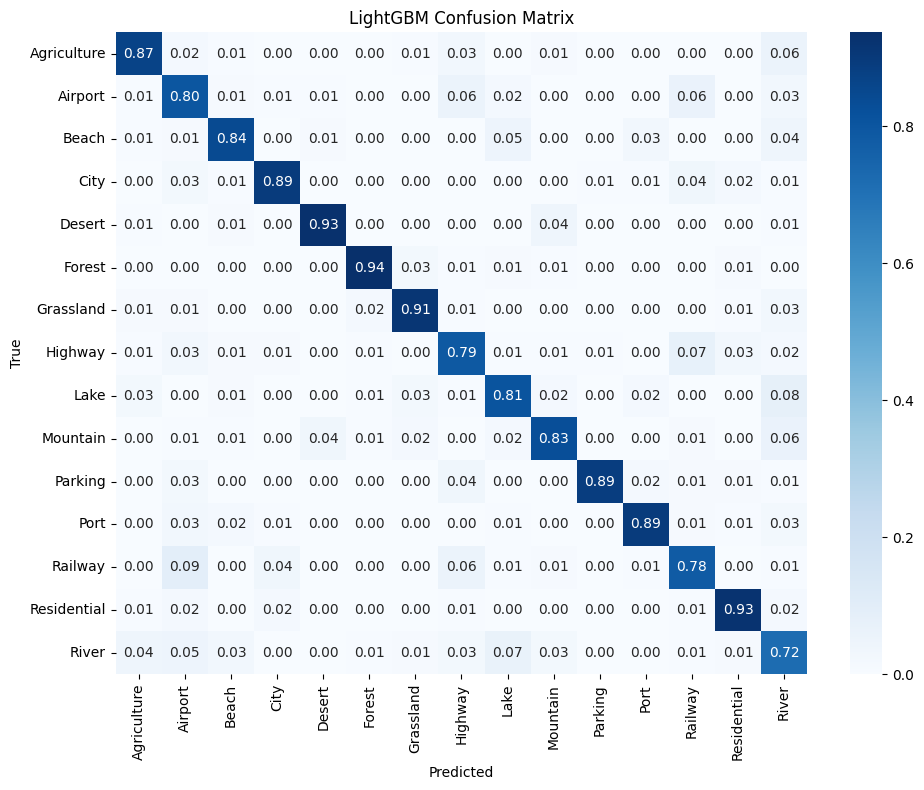

              precision    recall  f1-score   support

 Agriculture     0.8854    0.8688    0.8770       160
     Airport     0.7111    0.8000    0.7529       160
       Beach     0.8766    0.8438    0.8599       160
        City     0.9167    0.8938    0.9051       160
      Desert     0.9430    0.9313    0.9371       160
      Forest     0.9554    0.9375    0.9464       160
   Grassland     0.9125    0.9125    0.9125       160
     Highway     0.7730    0.7875    0.7802       160
        Lake     0.8113    0.8063    0.8088       160
    Mountain     0.8693    0.8313    0.8498       160
     Parking     0.9861    0.8875    0.9342       160
        Port     0.9167    0.8938    0.9051       160
     Railway     0.7764    0.7812    0.7788       160
 Residential     0.9024    0.9250    0.9136       160
       River     0.6461    0.7188    0.6805       160

    accuracy                         0.8546      2400
   macro avg     0.8588    0.8546    0.8561      2400
weighted avg     0.8588   

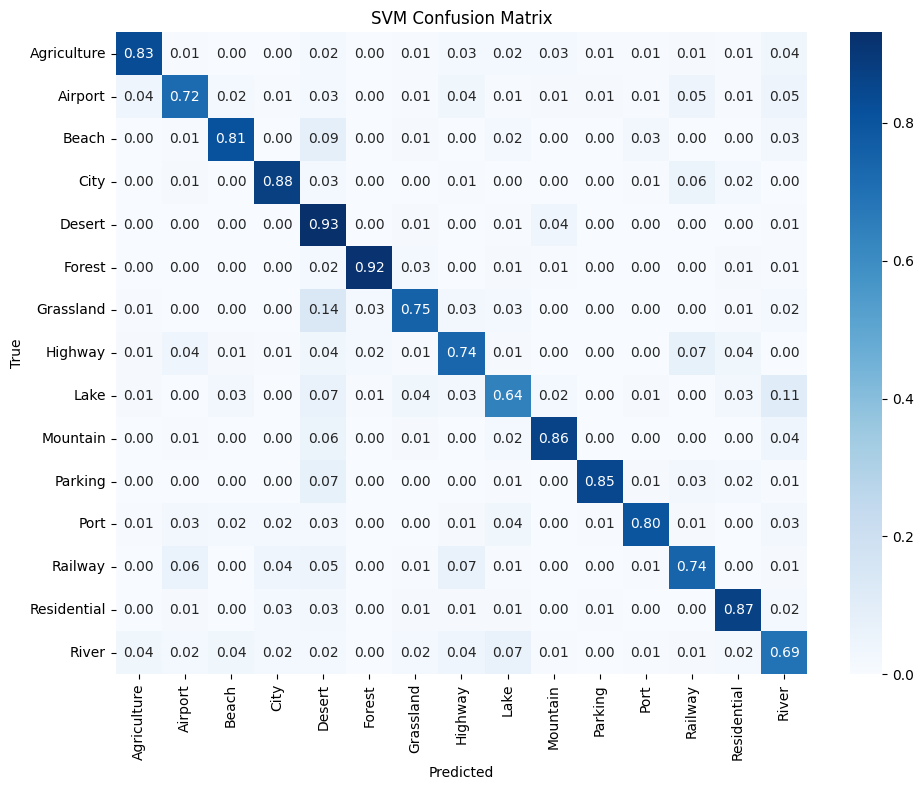

              precision    recall  f1-score   support

 Agriculture     0.8750    0.8313    0.8526       160
     Airport     0.7823    0.7188    0.7492       160
       Beach     0.8725    0.8125    0.8414       160
        City     0.8805    0.8750    0.8777       160
      Desert     0.5798    0.9313    0.7146       160
      Forest     0.9484    0.9187    0.9333       160
   Grassland     0.8276    0.7500    0.7869       160
     Highway     0.7329    0.7375    0.7352       160
        Lake     0.7203    0.6438    0.6799       160
    Mountain     0.8846    0.8625    0.8734       160
     Parking     0.9645    0.8500    0.9037       160
        Port     0.9014    0.8000    0.8477       160
     Railway     0.7484    0.7438    0.7461       160
 Residential     0.8476    0.8688    0.8580       160
       River     0.6529    0.6937    0.6727       160

    accuracy                         0.8025      2400
   macro avg     0.8146    0.8025    0.8048      2400
weighted avg     0.8146   

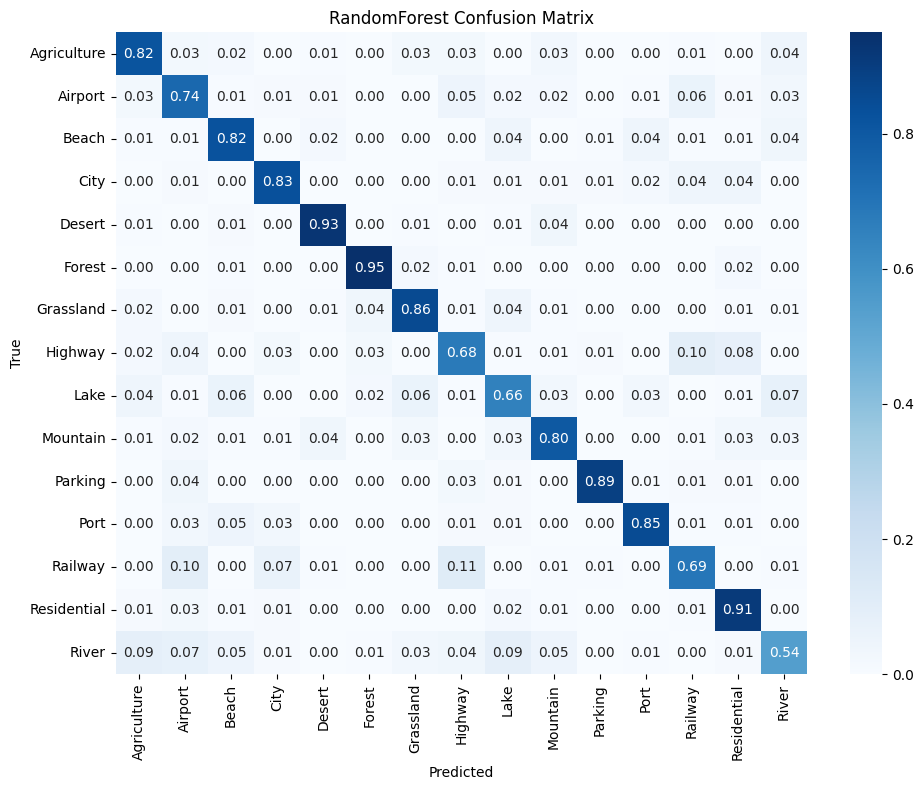

              precision    recall  f1-score   support

 Agriculture     0.7844    0.8187    0.8012       160
     Airport     0.6611    0.7438    0.7000       160
       Beach     0.7811    0.8250    0.8024       160
        City     0.8313    0.8313    0.8313       160
      Desert     0.9141    0.9313    0.9226       160
      Forest     0.9157    0.9500    0.9325       160
   Grassland     0.8354    0.8562    0.8457       160
     Highway     0.6987    0.6813    0.6899       160
        Lake     0.6908    0.6562    0.6731       160
    Mountain     0.7950    0.8000    0.7975       160
     Parking     0.9597    0.8938    0.9256       160
        Port     0.8831    0.8500    0.8662       160
     Railway     0.7351    0.6937    0.7138       160
 Residential     0.7935    0.9125    0.8488       160
       River     0.7016    0.5437    0.6127       160

    accuracy                         0.7992      2400
   macro avg     0.7987    0.7992    0.7976      2400
weighted avg     0.7987   

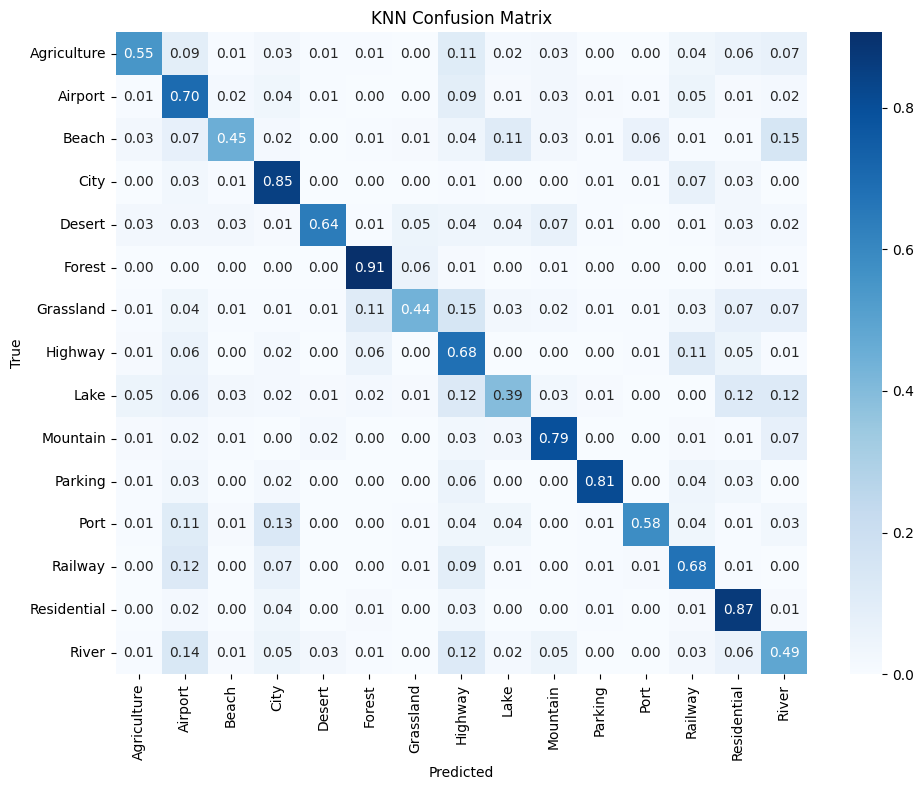

              precision    recall  f1-score   support

 Agriculture     0.7788    0.5500    0.6447       160
     Airport     0.4609    0.7000    0.5558       160
       Beach     0.7912    0.4500    0.5737       160
        City     0.6570    0.8500    0.7411       160
      Desert     0.8957    0.6438    0.7491       160
      Forest     0.8011    0.9062    0.8504       160
   Grassland     0.7527    0.4375    0.5534       160
     Highway     0.4176    0.6813    0.5178       160
        Lake     0.5676    0.3937    0.4649       160
    Mountain     0.7605    0.7937    0.7768       160
     Parking     0.9220    0.8125    0.8638       160
        Port     0.8532    0.5813    0.6914       160
     Railway     0.6034    0.6750    0.6372       160
 Residential     0.6376    0.8688    0.7354       160
       River     0.4561    0.4875    0.4713       160

    accuracy                         0.6554      2400
   macro avg     0.6904    0.6554    0.6551      2400
weighted avg     0.6904   

Epoch 1/3:  14%|█████▍                                | 43/300 [05:22<32:45,  7.65s/it, Loss=0.4637]

In [ ]:
run_methods()

### Unbalanced runs and comparison with resampling

In [ ]:
run_methods(type='unbalanced')

In [ ]:
run_methods(type='unbalanced', resample=True)

### Noise runs comparison

In [ ]:
run_methods(add_noise=True)

In [ ]:
run_methods(type='unbalanced', add_noise=True)

### Define `generate_gradcam` function

This function:
- Registers hooks to capture activations and gradients
- Performs forward and backward passes to compute Grad-CAM
- Generates a heatmap and overlays it on the original image
- Saves side-by-side visualization to the output directory

In [4]:
def generate_gradcam(model, image_path, class_names, output_path, model_name="resnet"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    if model_name == "resnet":
        target_layer = model.layer4[1].conv2
    elif model_name == "efficientnet":
        target_layer = model._blocks[-1]._project_conv
    elif model_name == "mobilenet":
        target_layer = model.features[-1][0]
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

    img = Image.open(image_path).convert("RGB")
    original_np = np.array(img)
    original_cv = cv2.cvtColor(original_np, cv2.COLOR_RGB2BGR)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()

    grad = gradients[0].detach().cpu().numpy()[0]
    act = activations[0].detach().cpu().numpy()[0]

    weights = np.mean(grad, axis=(1, 2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    if cam.max() > 0:
        cam /= cam.max()
    cam = cv2.resize(cam, original_cv.shape[:2][::-1])

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_cv, 0.5, heatmap, 0.5, 0)

    stitched = np.hstack((original_cv, overlay))

    os.makedirs(output_path, exist_ok=True)
    stitched_path = os.path.join(output_path, f"stitched_gradcam_{model_name}_{os.path.basename(image_path)}")
    cv2.imwrite(stitched_path, stitched)

    true_class = os.path.basename(os.path.dirname(image_path))
    predicted_class = class_names[pred_class]

    print(f"✅ Saved: {stitched_path} | GT: {true_class}, Pred: {predicted_class}")
    return true_class, predicted_class


### Unified Grad-CAM Generator for ResNet, EfficientNet, and MobileNet

This cell defines a single `run_batch_gradcam_unified` function that handles Grad-CAM generation for any of the three models:
- **ResNet-18**
- **EfficientNet-B0**
- **MobileNetV2**

It:
- Loads the corresponding model and classifier layer
- Loads the model weights
- Generates Grad-CAM visualizations on 1 test image per class
- Saves side-by-side visual + prediction reports

To use:
```python
run_batch_gradcam_unified("resnet")
run_batch_gradcam_unified("efficientnet")
run_batch_gradcam_unified("mobilenet")

In [8]:
def run_batch_gradcam_unified(model_name, model_path=None):
    print(f"\n📸 Generating Grad-CAM for {model_name.title()}...\n")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # === Load model based on type ===
    if model_name == "resnet":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 15)
        default_path = "models/resnet18_finetuned.pth"
    elif model_name == "efficientnet":
        model = EfficientNet.from_name('efficientnet-b0')
        model._fc = nn.Linear(model._fc.in_features, 15)
        default_path = "models/efficientnet_b0.pth"
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 15)
        default_path = "models/mobilenet_v2.pth"
    else:
        raise ValueError(f"❌ Unsupported model name: {model_name}")

    model_path = model_path or default_path
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # === Test directory setup ===
    test_dir = "data/test"
    class_names = sorted(os.listdir(test_dir))

    timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    output_dir = f"gradcam_outputs/{model_name}_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)

    log_path = os.path.join(output_dir, "report.txt")
    with open(log_path, "w", encoding="utf-8") as log_file:
        log_file.write(f"Grad-CAM Report\nModel: {model_name.title()}\nTimestamp: {timestamp}\n\n")

        for cls in class_names:
            class_dir = os.path.join(test_dir, cls)
            if not os.path.isdir(class_dir): continue

            images = os.listdir(class_dir)
            if not images: continue

            image_path = os.path.join(class_dir, images[0])
            _, pred_class = generate_gradcam(model, image_path, class_names, output_dir, model_name=model_name)
            log_file.write(f"{os.path.basename(image_path)} | Original: {cls} | Predicted: {pred_class}\n")

    print(f"\n✅ Grad-CAM report saved to: {log_path}")